# Lineaar regression with iterative optimisation(`SGDRegressor`)

It gives conrtrol over optimisation through a number of hyperparameters.

In [18]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import SGDRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import validation_curve

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [19]:
np.random.seed(306)

shuffle_split_cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

Split into test and train

In [20]:
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)
com_train_features, test_features, com_train_labels, test_labels = train_test_split(features, labels, random_state=42)

Split into train and dev

In [43]:
train_features, dev_features, train_labels, dev_labels = train_test_split(com_train_features, com_train_labels, random_state=42)

## Baseline `SGDRegressor`

* STEP 1: Instantiate baseline `SGDRegressor` with default parameters.
* STEP 2: Train the model with training feature matrix and labels.
* STEP 3: Obtain the score on the train and dev data

In [22]:
sgd = SGDRegressor(random_state=42)
sgd.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd.predict(dev_features))

print("Mean Absolute Error on Training set: ", train_mae)
print("Mean Absolute Error on development set: ", dev_mae)

Mean Absolute Error on Training set:  309190327803747.2
Mean Absolute Error on development set:  311959782899622.1


Errors are too large!!!

## Adding a feature scaling step

SGD is sensitive to feature scaling.

In [23]:
sgd_pipeline = Pipeline([("feature_scaling", StandardScaler()),
                        ("sgd", SGDRegressor())])

sgd_pipeline.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))

print("Mean Absolute Error on Training set: ", train_mae)
print("Mean Absolute Error on development set: ", dev_mae)

Mean Absolute Error on Training set:  0.7120658904697417
Mean Absolute Error on development set:  0.9804229242073539


## Step-wise training of SGDRegressor

* STEP 1: Instantiate `SGDRegressor` with `warm_start=True` and `tol=-np.infty`
* STEP 2: Train SGD step by step and recod regression loss in each step.
* STEP 3: Plot learning curve and see if there are any issues in training.

Text(0.5, 1.0, 'Learning curve: eta0= 0.0100')

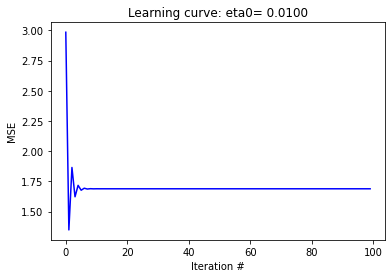

In [24]:
eta0 = 1e-2
sgd_pipeline = Pipeline([("feature_scaling", StandardScaler()),
                        ("sgd", SGDRegressor(max_iter=1, tol=-np.infty,
                                                warm_start=True,
                                                random_state=42))])

loss = []

for epoch in range(100):
    sgd_pipeline.fit(train_features, train_labels)
    loss.append(mean_squared_error(train_labels, sgd_pipeline.predict(train_features)))

plt.plot(np.arange(len(loss)), loss, 'b-')
plt.xlabel('Iteration #')
plt.ylabel('MSE')
plt.title(f'Learning curve: eta0={eta0: .4f}')

The loss reduced intially and then increased. This could be due to large training rates. We will reduce the rate by a factor of 10 and repeat the process.

Text(0.5, 1.0, 'Learning curve: eta0= 0.0010')

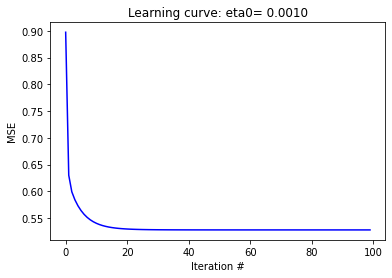

In [25]:
eta0 = 1e-3
sgd_pipeline = Pipeline([("feature_scaling", StandardScaler()),
                        ("sgd", SGDRegressor(max_iter=1, tol=-np.infty,
                                                warm_start=True, eta0=eta0,
                                                random_state=42))])

loss = []

for epoch in range(100):
    sgd_pipeline.fit(train_features, train_labels)
    loss.append(mean_squared_error(train_labels, sgd_pipeline.predict(train_features)))

plt.plot(np.arange(len(loss)), loss, 'b-')
plt.xlabel('Iteration #')
plt.ylabel('MSE')
plt.title(f'Learning curve: eta0={eta0: .4f}')

This is an ideal learning curve where the train loss reduce monotonically as the training progresses.


In [26]:
print('# iteration before reaching convergence criteria: ', 
        sgd_pipeline[-1].n_iter_)

print ("#Weight updated:", sgd_pipeline[-1].t_)

# iteration before reaching convergence criteria:  1
#Weight updated: 11611.0


In [27]:
train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))

print("Mean Absolute Error on Training set: ", train_mae)
print("Mean Absolute Error on development set: ", dev_mae)

Mean Absolute Error on Training set:  0.5333732983042573
Mean Absolute Error on development set:  0.5190150280908042


## Fixing learning rate through validation curves

* STEP 1: Provide the list of values to be tried for a hyper=parameter.
* STEP 2: Instantiate an object of `validation_curve` with estimator, training features and label. Set `scoring` parameter to relevant score.
* STEP 3: Convert sccores to error.
* STEP 4: Fix the hyper parameter value where the test error is the least. 

In [30]:
%%time

eta0 = [1e-5, 1e-4, 1e-3, 1e-2]
train_scores, test_scores = validation_curve(
                                            sgd_pipeline, com_train_features, com_train_labels, param_name="sgd__eta0",
                                            param_range=eta0, cv = shuffle_split_cv, scoring="neg_mean_squared_error",
                                            n_jobs=2)

train_errors, test_errors = -train_scores, -test_scores

CPU times: total: 234 ms
Wall time: 1.92 s


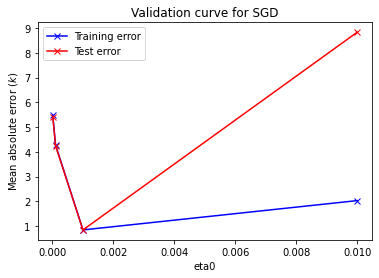

In [33]:
plt.plot(eta0, train_errors.mean(axis=1), 'b-x', label='Training error')
plt.plot(eta0, test_errors.mean(axis=1), 'r-x', label='Test error')
plt.legend()
plt.xlabel("eta0")
plt.ylabel("Mean absolute error ($k$)")
_ = plt.title("Validation curve for SGD")

## `SGDRegressor`

In [36]:
sgd_pipeline = Pipeline([("feature_scaling", StandardScaler()),
                        ("sgd", SGDRegressor(max_iter=500,
                                            early_stopping=True,
                                            eta0 = 1e-3,
                                            tol=1e-3,
                                            validation_fraction=0.2,
                                            n_iter_no_change=5,
                                            average=10,
                                            random_state=42))])

sgd_pipeline.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))

print("Mean Absolute Error on Training set: ", train_mae)
print("Mean Absolute Error on development set: ", dev_mae)

Mean Absolute Error on Training set:  0.5433287489797834
Mean Absolute Error on development set:  0.5345612073911922


In [37]:
print('# iteration before reaching convergence criteria: ', 
        sgd_pipeline[-1].n_iter_)

print ("#Weight updated:", sgd_pipeline[-1].t_)

# iteration before reaching convergence criteria:  35
#Weight updated: 406351.0


In [39]:
#learning rate changed to constant from inverse scaling(default)
sgd_pipeline = Pipeline([("feature_scaling", StandardScaler()),
                        ("sgd", SGDRegressor(max_iter=500,
                                            early_stopping=True,
                                            eta0 = 1e-3,
                                            tol=1e-3,
                                            learning_rate='constant',
                                            validation_fraction=0.2,
                                            n_iter_no_change=5,
                                            average=10,
                                            random_state=42))])

sgd_pipeline.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))

print("Mean Absolute Error on Training set: ", train_mae)
print("Mean Absolute Error on development set: ", dev_mae)

print('\n# iteration before reaching convergence criteria: ', 
        sgd_pipeline[-1].n_iter_)

print ("#Weight updated:", sgd_pipeline[-1].t_)

Mean Absolute Error on Training set:  0.5528203432984674
Mean Absolute Error on development set:  0.5689568216133667

# iteration before reaching convergence criteria:  11
#Weight updated: 127711.0


In [40]:
#learning rate changed to adaptive from inverse scaling(default)
sgd_pipeline = Pipeline([("feature_scaling", StandardScaler()),
                        ("sgd", SGDRegressor(max_iter=500,
                                            early_stopping=True,
                                            eta0 = 1e-3,
                                            tol=1e-3,
                                            learning_rate='adaptive',
                                            validation_fraction=0.2,
                                            n_iter_no_change=5,
                                            average=10,
                                            random_state=42))])

sgd_pipeline.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))

print("Mean Absolute Error on Training set: ", train_mae)
print("Mean Absolute Error on development set: ", dev_mae)

print('\n# iteration before reaching convergence criteria: ', 
        sgd_pipeline[-1].n_iter_)

print ("#Weight updated:", sgd_pipeline[-1].t_)

Mean Absolute Error on Training set:  0.5375525445454805
Mean Absolute Error on development set:  0.5200254740759911

# iteration before reaching convergence criteria:  40
#Weight updated: 464401.0


## Setting `max_iters`

In [41]:
max_iter = np.ceil(1e6/com_train_features.shape[0])
max_iter

65.0

In [42]:
sgd_pipeline = Pipeline([("feature_scaling", StandardScaler()),
                        ("sgd", SGDRegressor(max_iter=max_iter,
                                            early_stopping=True,
                                            eta0 = 1e-3,
                                            tol=1e-3,
                                            learning_rate='adaptive',
                                            validation_fraction=0.2,
                                            n_iter_no_change=5,
                                            average=10,
                                            random_state=42))])

sgd_pipeline.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))

print("Mean Absolute Error on Training set: ", train_mae)
print("Mean Absolute Error on development set: ", dev_mae)

print('\n# iteration before reaching convergence criteria: ', 
        sgd_pipeline[-1].n_iter_)

print ("#Weight updated:", sgd_pipeline[-1].t_)

Mean Absolute Error on Training set:  0.5375525445454805
Mean Absolute Error on development set:  0.5200254740759911

# iteration before reaching convergence criteria:  40
#Weight updated: 464401.0
